# <span style='color:#00dd00'>Train the Early Fusion (EF) Model</span>
## <span style='color:#dd0000'>**Note: To train this model, first we need to pre-train the baseline model, and then train this model.**</span>

Model './checkpoint/MultiModal/S+E L257 EF cat0 pre_CNN512_LSTM_384_L384 L257 (zero_pad).pt' loaded.
Model './checkpoint/MultiModal/S CNN512 LSTM_384_Linear (norm n100) V2.pt' loaded.
Cache clean training data ...
../Dataset/elec/E173.csv not found.
Training set size: 222, Validation set size: 27
Training: S+E L257 EF cat0 pre_CNN512_LSTM_384_L384 L257 (zero_pad)


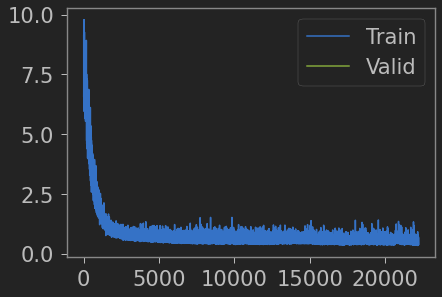

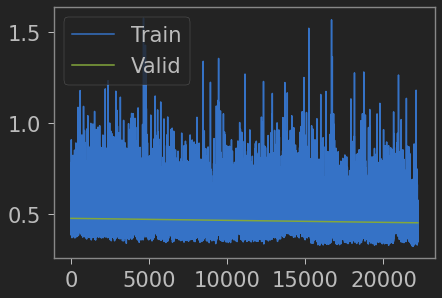

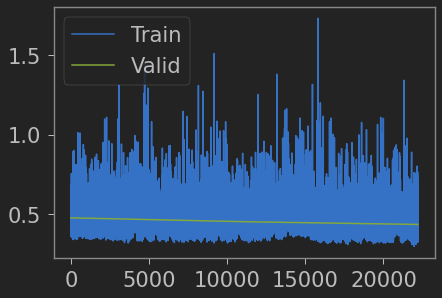

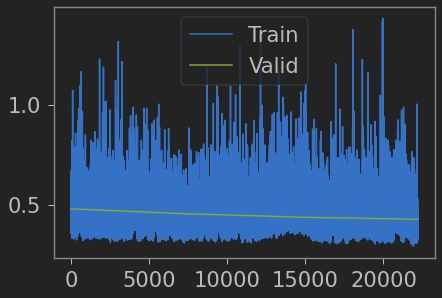

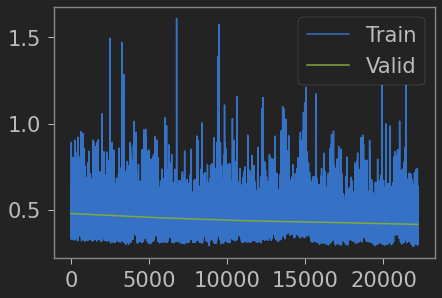

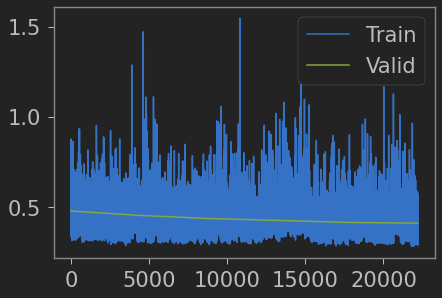

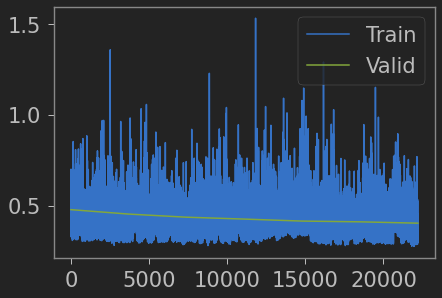

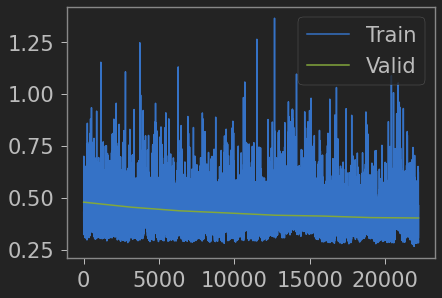

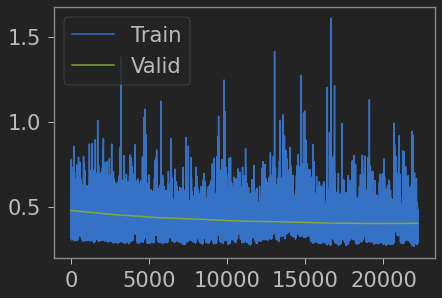

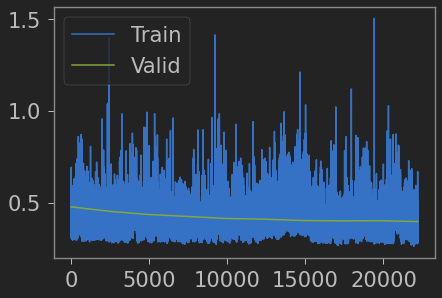

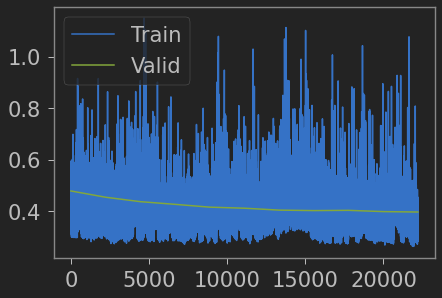

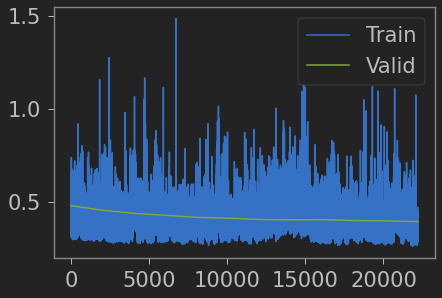

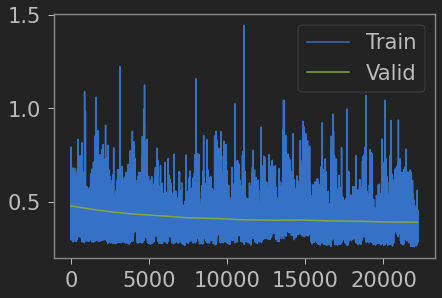

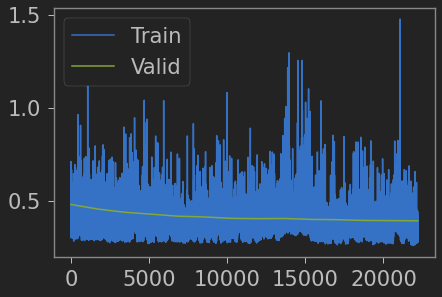

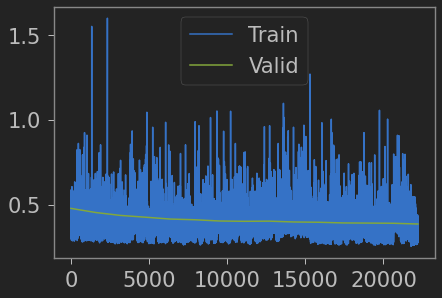

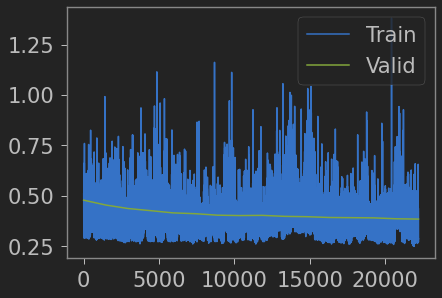

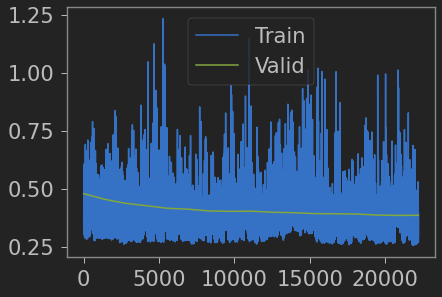

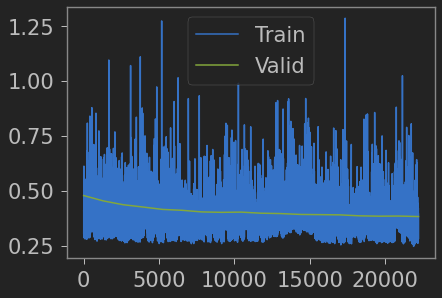

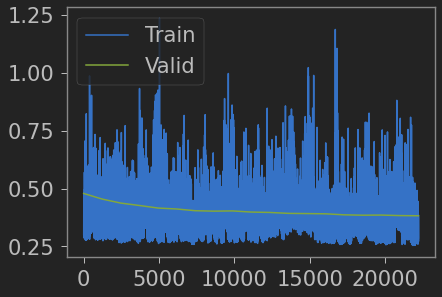

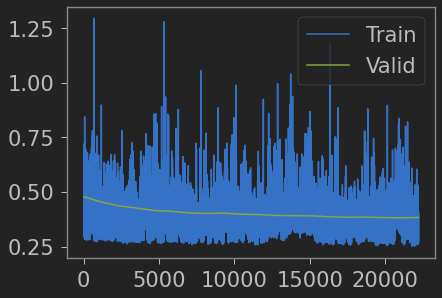

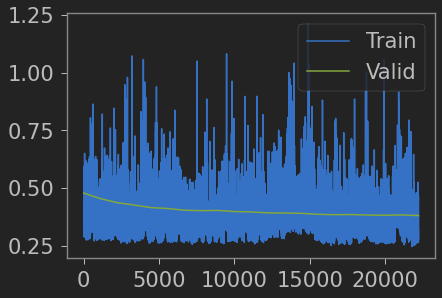

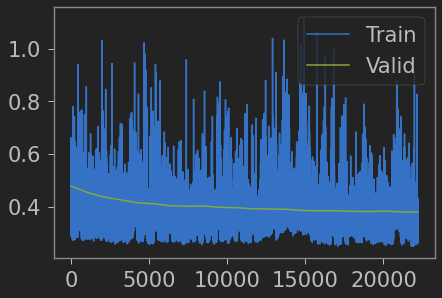

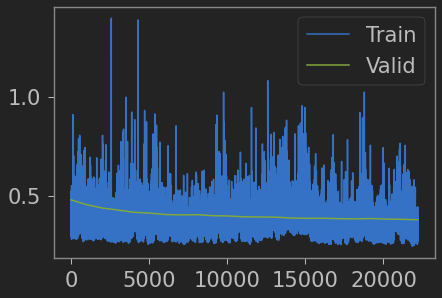

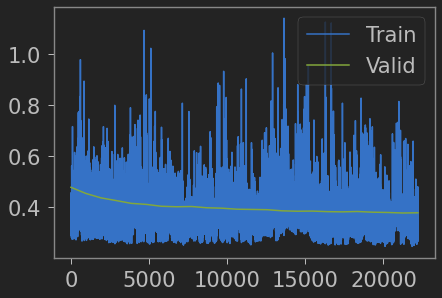

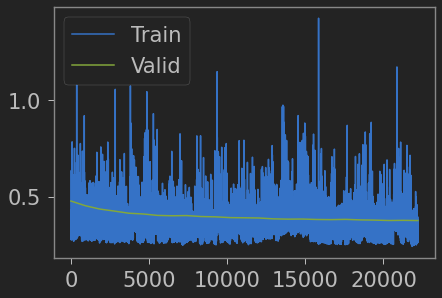

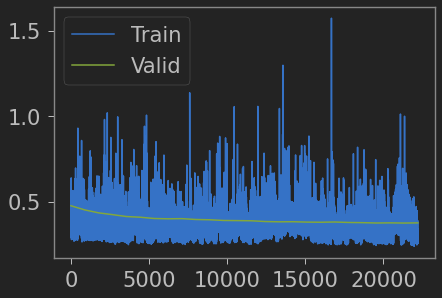

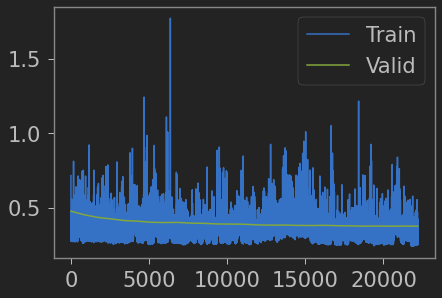

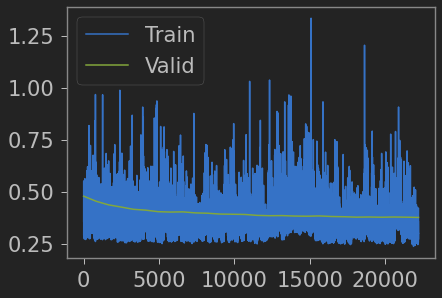

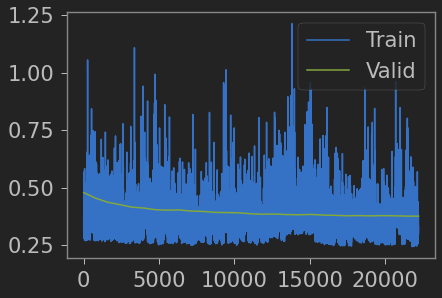

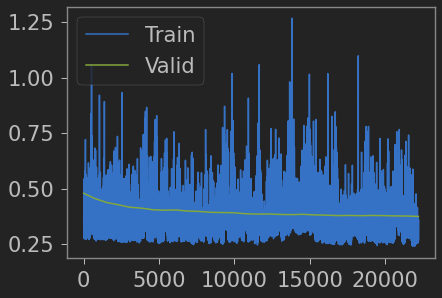

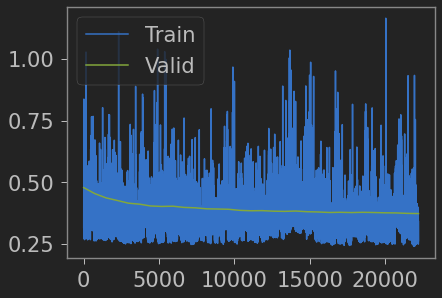

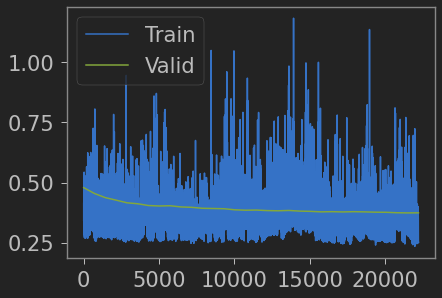

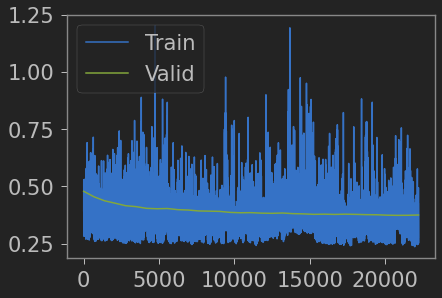

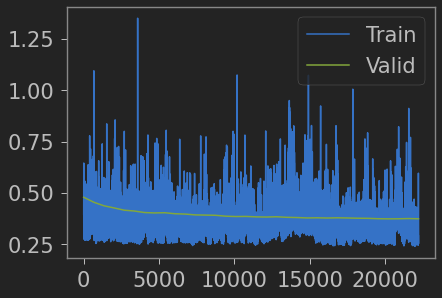

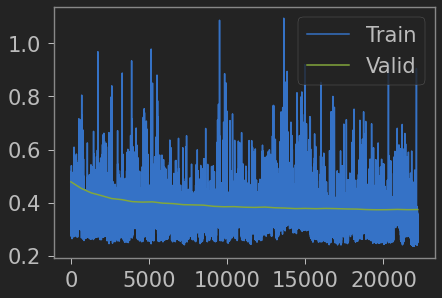

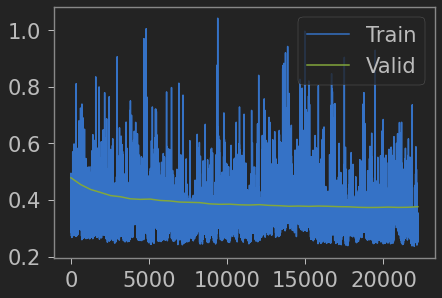

In [1]:
# Set the chart to dark mode
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False, fscale=2, figsize=(8, 6))

from main import *

if __name__ == '__main__':
    args.device = 'cuda:1'
    
    # ===== Build/Load MultiModal_SE =====
    model_name = 'S+E L257 EF cat0 pre_CNN512_LSTM_384_L384 L257 (zero_pad) (data aug)'
    
    model = MultiModal_SE()
    model, from_epoch, valid_loss_threshold = model.load_model(
        os.path.join(args.MM_checkpoint_path, f'{model_name}.pt'),
        device=args.device
    )
    
    baseline_model, _, _ = MultiModal_SE().load_model(
        os.path.join(args.MM_checkpoint_path, 'S CNN512 LSTM_384_Linear (norm n100) V2.pt'),
        device=args.device
    )
    from_epoch, valid_loss_threshold = 0, 1e9
    
    # (N, Seq, 257) -> (N, Seq, 4 * 128)
#     model.S_Encoder = None
        
    # (N, Seq, 124) -> (N, Seq, 12) or None
    model.E_Encoder = nn.Sequential(OrderedDict([
        ('L_1', nn.Linear(124, 257, bias=False)),
    ]))
    
    # (N, Seq, 2 Encoders input size) -> (N, Seq, fusion size) or None
    model.Fusion_layer = nn.Sequential(OrderedDict([
        ('unsqueeze', Unsqueeze(0)),
        ('conv_0_0', nn.Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
        *list(baseline_model.S_Encoder._modules['CNN_model']._modules.items())[2:],
        *list(baseline_model.S_Decoder._modules.items())[:-2],
    ]))
    
    # [ Train a new S_Decoder or Load pre-trained S_Decoder ]
    # (N, Seq, fusion size or S_Encoder latent size) -> (N, Seq, 257)
    model.S_Decoder = nn.Sequential(OrderedDict([
        ('L_6', nn.Linear(384, 257, bias=False)),
        ('relu_6', nn.LeakyReLU(negative_slope=0.3, inplace=True))
    ]))
#     model.S_Decoder = nn.Sequential(OrderedDict([
#         *list(baseline_model.S_Decoder._modules.items())[-2:]
#     ]))
    
    # (N, Seq, fusion size or S_Encoder latent size) -> (N, Seq, 124) or None
#     model.E_Decoder = nn.Sequential(OrderedDict([
#         ('L_6', nn.Linear(384, 124, bias=False)),
#         ('relu_6', nn.LeakyReLU(negative_slope=0.3, inplace=True)),
#     ]))
    
    # Fixed pre-trained model (Default: Not fixed)
#     for name, para in model.S_Encoder.named_parameters():
#         para.requires_grad = False
#     for name, para in model.Fusion_layer.named_parameters():
#         if 'lstm_4' not in name:
#             para.requires_grad = False
#     for name, para in model.S_Decoder.named_parameters():
#             para.requires_grad = False

    model.is_late_fusion = False
    model.fusion_type = 'concat'
    model.fusion_channel = 0
    model.use_norm = True
    
    model.to(args.device)
    del baseline_model
    
    # ===== Load clean data =====
    print('Cache clean training data ...')
    dataset = cache_clean_data(split_ratio=args.split_ratio, dataset_path=args.dataset_path, device=args.device)
    print(f"Training set size: {len(dataset['Train'])}, Validation set size: {len(dataset['Valid'])}")
    
    args.lr /= 5
    loss_fn = nn.MSELoss()
    feat_loss_fn = None
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
    
    # ===== Training =====
    print(f'Training: {model_name}')
    train(model, dataset,
          from_epoch, args.batch_size,
          valid_loss_threshold, args.loss_coef,
          loss_fn, feat_loss_fn, optimizer,
          save_filename=os.path.join(args.MM_checkpoint_path, model_name),
          dataset_path=args.dataset_path,
          use_elec=True, elec_only=False, use_zero_pad=True,
    )